Importing Packages

In [81]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import random
from random import sample

import os
import glob
import cv2

Defining Changeable Variables

In [82]:
ROOT_DIR = "asl_alphabet_train"
PIXELSIZE = 32 #28, 32
PIXELTIMES = 1024 # 784, 1024

MAX_IMAGES_PER_CLASS = 110  # Set the maximum number of images per class
TRAIN_SIZE = 3000 # 29 * 110 = 3190

# Data Importation and Pre-Processing

In [83]:
image_data = {}

for class_folder in os.listdir(ROOT_DIR):
    class_path = os.path.join(ROOT_DIR, class_folder)
    if os.path.isdir(class_path):
        class_images = []
        for image_file in glob.glob(os.path.join(class_path, "*.jpg")):  # Change the file extension as needed
            class_images.append(image_file)
        image_data[class_folder] = class_images

In [84]:
for class_name, images in image_data.items():
    print(f"Class: {class_name}\tCount: {len(images)}")

Class: A	Count: 3000
Class: B	Count: 3000
Class: C	Count: 3000
Class: D	Count: 3000
Class: del	Count: 3000
Class: E	Count: 3000
Class: F	Count: 3000
Class: G	Count: 3000
Class: H	Count: 3000
Class: I	Count: 3000
Class: J	Count: 3000
Class: K	Count: 3000
Class: L	Count: 3000
Class: M	Count: 3000
Class: N	Count: 3000
Class: nothing	Count: 3000
Class: O	Count: 3000
Class: P	Count: 3000
Class: Q	Count: 3000
Class: R	Count: 3000
Class: S	Count: 3000
Class: space	Count: 3000
Class: T	Count: 3000
Class: U	Count: 3000
Class: V	Count: 3000
Class: W	Count: 3000
Class: X	Count: 3000
Class: Y	Count: 3000
Class: Z	Count: 3000


In [85]:
class_number_dict = {}

images = []
classes = []
classNumber = 0

for class_name, image_paths in image_data.items():
    class_count = 0  # Initialize a counter for the current class
    for image_path in image_paths:
        if isinstance(image_path, str) and os.path.exists(image_path):
            image = cv2.imread(image_path, 0)
            image = cv2.resize(image, (PIXELSIZE, PIXELSIZE), interpolation=cv2.INTER_LINEAR)

            if image is not None:  # Check if the image was successfully loaded
                images.append(image)
                classes.append(classNumber)
                class_count += 1

            if class_count >= MAX_IMAGES_PER_CLASS:
                break  # Stop loading images for the current class

    class_number_dict[class_name] = classNumber
    classNumber += 1

In [86]:
# Combine the two lists into pairs
combined_lists = list(zip(classes, images))

# Shuffle the pairs
random.shuffle(combined_lists)

# Unzip the shuffled pairs back into separate lists
classes, images = zip(*combined_lists)

In [87]:
classes = np.array(classes)
images = np.array(images)

In [88]:
images = images.reshape(-1, PIXELTIMES)

In [89]:
X_train = images[0:TRAIN_SIZE]
y_train = classes[0:TRAIN_SIZE]

X_test = images[TRAIN_SIZE:classes.size]
y_test = classes[TRAIN_SIZE:images.size]

In [90]:
X_train = X_train.T
y_train = y_train.T

X_test = X_test.T
y_test = y_test.T

X_train = X_train / 255.
X_test = X_test / 255.

In [91]:
print(X_train.shape)
print(y_train.shape)

(1024, 3000)
(3000,)


# Exploratory Data Analysis

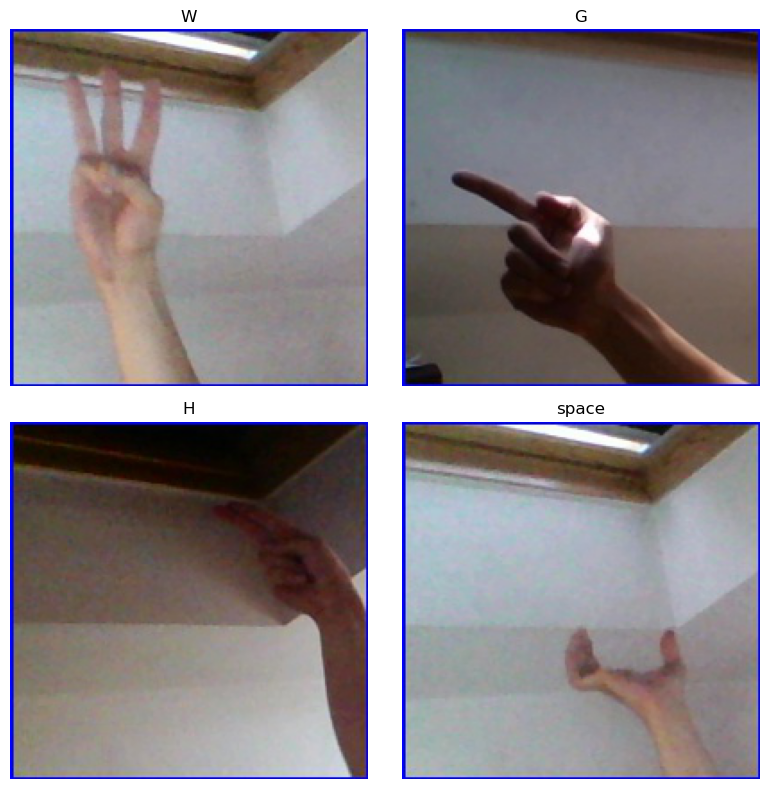

In [92]:
# Select 4 random classes
random_classes = random.sample(list(image_data.keys()), 4)

# Create a 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot one random image from each class
for i, class_name in enumerate(random_classes):
    row = i // 2
    col = i % 2
    random_image = random.choice(image_data[class_name])
    img = mpimg.imread(random_image)
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Neural Network Building

In [93]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((TRAIN_SIZE, PIXELSIZE))
    one_hot_Y[np.arange(TRAIN_SIZE), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [94]:
class NeuralNet:
    def __init__(self):
        self.W1 = np.random.rand(PIXELSIZE, PIXELTIMES) - 0.5
        self.B1 = np.random.rand(PIXELSIZE, 1) - 0.5
        self.W2 = np.random.rand(PIXELSIZE, PIXELSIZE) - 0.5
        self.B2 = np.random.rand(PIXELSIZE, 1) - 0.5

    def forward_prop(self, X):
        self.Z1 = self.W1.dot(X) + self.B1
        self.A1 = ReLU(self.Z1)
        self.Z2 = self.W2.dot(self.A1) + self.B2
        self.A2 = softmax(self.Z2)

    def backward_prop(self, X, Y):
        one_hot_Y = one_hot(Y)
        dZ2 = self.A2 - one_hot_Y

        self.dW2 = 1 / TRAIN_SIZE * dZ2.dot(self.A1.T)
        self.db2 = 1 / TRAIN_SIZE * np.sum(dZ2)

        dZ1 = self.W2.T.dot(dZ2) * ReLU_deriv(self.Z1)

        self.dW1 = 1 / TRAIN_SIZE * dZ1.dot(X.T)
        self.db1 = 1 / TRAIN_SIZE * np.sum(dZ1)
        
    def update_params(self, alpha):
        self.W1 = self.W1 - alpha * self.dW1
        self.B1 = self.B1 - alpha * self.db1    
        self.W2 = self.W2 - alpha * self.dW2
        self.B2 = self.B2 - alpha * self.db2

    def train(self, X, Y, alpha, iterations):
        history = []

        for i in range(iterations):
            self.forward_prop(X)
            self.backward_prop(X, Y)
            self.update_params(alpha)
        
            if i % 100 == 0:
                acc = np.sum(np.argmax(self.A2, 0) == Y) / Y.size
                history.append([i, acc])

                print(f"Iteration: {i}\t\tAccuracy: {acc * 100:.2f}%")

        return history

    def get_predictions(self, testSet):
        Z1 = self.W1.dot(testSet) + self.B1
        A1 = ReLU(Z1)
        Z2 = self.W2.dot(A1) + self.B2
        A2 = softmax(Z2)
        return np.argmax(A2, 0)
    
    def get_accuracy(self, Xset, Yset):
        return np.sum(self.get_predictions(Xset) == Yset) / Yset.size
    
    def get_weights_bias(self):
        return self.W1, self.B1, self.W2, self.B2
    
    def save_model(self):
        # Create a dictionary to store the weights and biases
        network = {
            'weights_1': self.W1,
            'biases_1': self.B1,
            'weights_2': self.W2,
            'biases_2': self.B2,
            'class_number_dict': class_number_dict
        }

        # Save the weights and biases to a binary file
        np.save('neural_network_weights.npy', network)

# Training the Model

In [95]:
nn = NeuralNet()
history = nn.train(X_train, y_train, 0.10, 10000)
nn.save_model()

Iteration: 0		Accuracy: 3.57%
Iteration: 100		Accuracy: 4.97%
Iteration: 200		Accuracy: 6.57%
Iteration: 300		Accuracy: 14.50%
Iteration: 400		Accuracy: 15.33%
Iteration: 500		Accuracy: 30.97%
Iteration: 600		Accuracy: 23.97%
Iteration: 700		Accuracy: 34.57%
Iteration: 800		Accuracy: 32.60%
Iteration: 900		Accuracy: 38.80%
Iteration: 1000		Accuracy: 36.63%
Iteration: 1100		Accuracy: 40.77%
Iteration: 1200		Accuracy: 46.33%
Iteration: 1300		Accuracy: 48.30%
Iteration: 1400		Accuracy: 47.00%
Iteration: 1500		Accuracy: 44.67%
Iteration: 1600		Accuracy: 55.13%
Iteration: 1700		Accuracy: 52.97%
Iteration: 1800		Accuracy: 57.13%
Iteration: 1900		Accuracy: 56.17%
Iteration: 2000		Accuracy: 56.10%
Iteration: 2100		Accuracy: 62.73%
Iteration: 2200		Accuracy: 58.03%
Iteration: 2300		Accuracy: 54.30%
Iteration: 2400		Accuracy: 56.80%
Iteration: 2500		Accuracy: 57.37%
Iteration: 2600		Accuracy: 66.80%
Iteration: 2700		Accuracy: 66.93%
Iteration: 2800		Accuracy: 58.63%
Iteration: 2900		Accuracy: 36

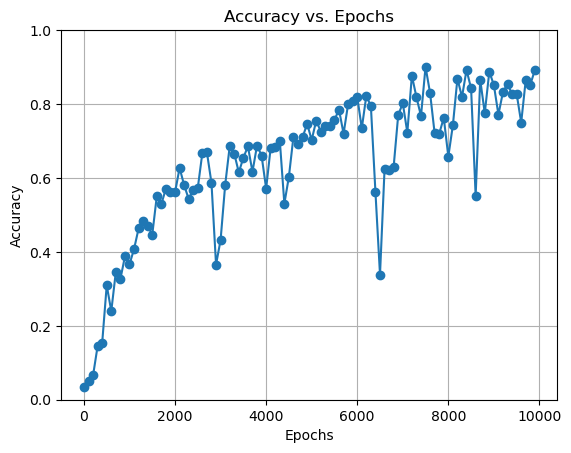

In [96]:
# Create the line graph
plt.plot([item[0] for item in history], [item[1] for item in history], marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.ylim(0, 1)

# Display the graph
plt.grid(True)
plt.show()

# Testing the Model

In [97]:
print(f"Test Accuracy: {nn.get_accuracy(X_test, y_test) * 100:.2f}%")

Test Accuracy: 82.63%


Print predictions on test data

In [98]:
def predict(w1, b1, w2, b2, X):
    Z1 = w1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = w2.dot(A1) + b2
    A2 = softmax(Z2)
    return np.argmax(A2, 0)

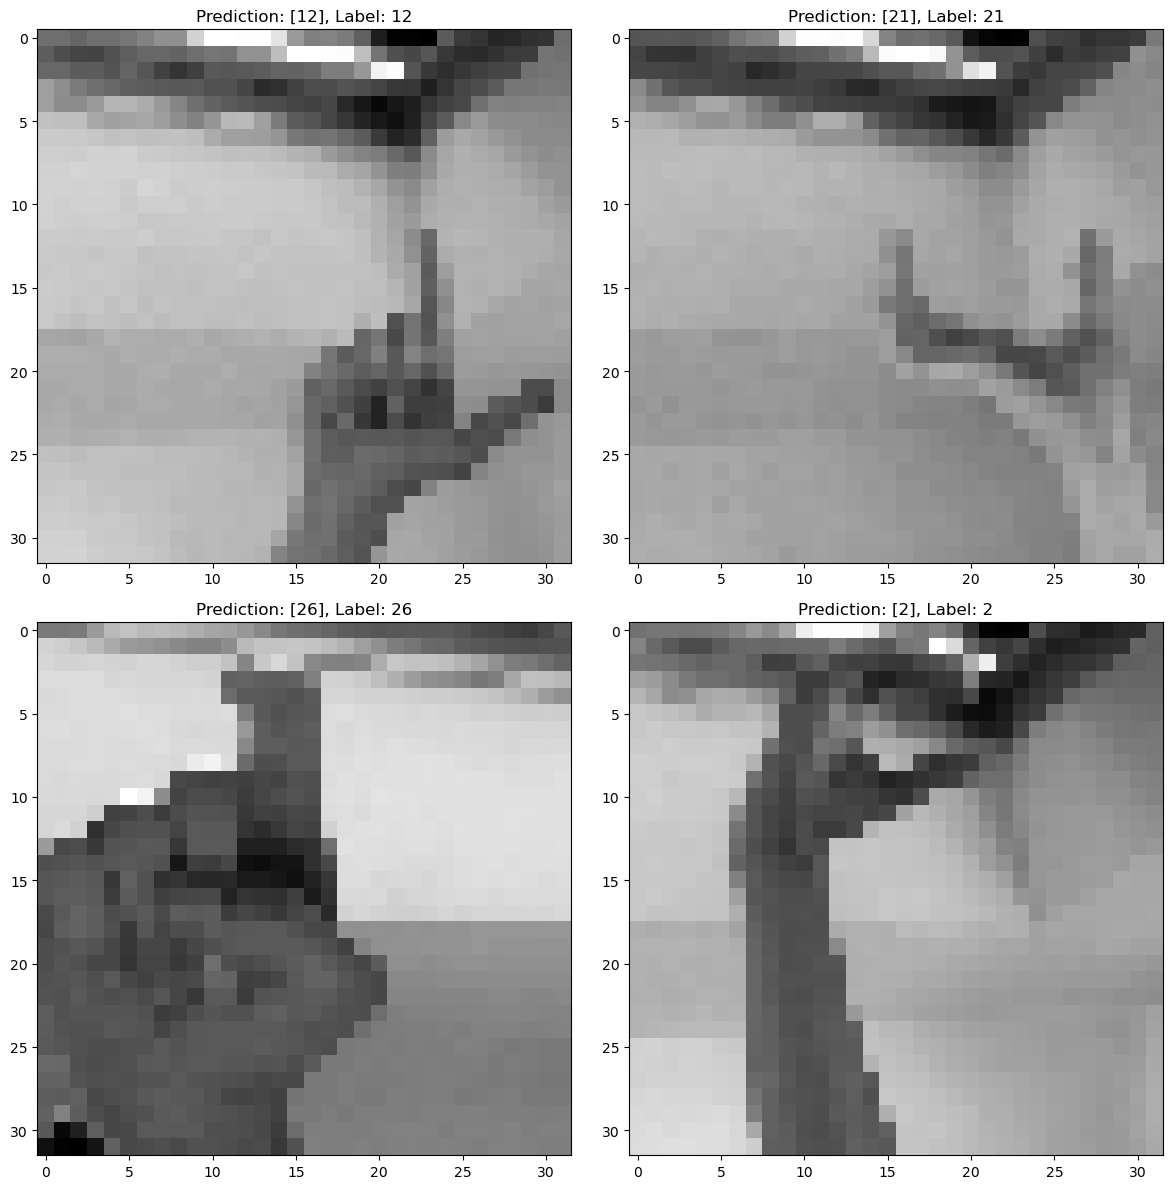

In [99]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Define the indices you want to test
indices = [0, 1, 2, 3]

for i, ax in enumerate(axes.flat):
    if i < len(indices):
        index = indices[i]
        current_image = X_test[:, index, None]
        label = y_test[index]

        w1, b1, w2, b2 = nn.get_weights_bias()
        prediction = predict(w1, b1, w2, b2, current_image)

        ax.imshow(current_image.reshape((PIXELSIZE, PIXELSIZE)) * 255, interpolation='nearest', cmap='gray')
        ax.set_title(f"Prediction: {prediction}, Label: {label}")
    else:
        ax.axis('off')  # Turn off empty subplots

plt.tight_layout()
plt.show()